# Analyzing NYTbd Sample 4
<br>
This notebook is looking at the NYTbd Sample 4 content analyzed by ACCENT and PETRARCH2 to identify current limitations with PETRARCH2 and to try and devise solutions. 

In [3]:
# Setup Environment
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.parse import CoreNLPParser

import pandas as pd

import pprint
import nltk

from nltk.tree import *
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Link to Java Server for Standford CoreNLP
<br>
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -port 9000 -timeout 100000

In [4]:
# Connect to Server
parser = CoreNLPParser('http://localhost:9000')
depr = CoreNLPDependencyParser('http://localhost:9000')

#### Write Some Functions for Parsing Text

In [5]:
# Core Parser- save as df['parsed']
def core_parser(df, col):
    parse = []
    i = ""
    for i in range(len(df)):
        parse.append(i)
        parse[i] = next(parser.raw_parse(df[col].iloc[i]))
    return parse

# Dependency Parser- save as df['dep']
def dep_parser(df, col):
    dep = []
    i = ""
    for i in range(len(df)):
        dep.append(i)
        dep[i] = next(depr.raw_parse(df[col].iloc[i]))
    return dep

# For easy display of both parse trees, text, and code
def easy_read(corp, index_num):
    display(corp['parsed'].iloc[index_num])
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    
# function to display only constituency parse with POS tags with text and code
def parsed_output(corp, index_num):
    display(corp['parsed'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    display("AID = " + str(corp.iloc[index_num].loc['aid']))
    
# function to display only dependency parse with text and code
def dependency_output(corp, index_num):
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))
    
# function to display constituency parse of a single sentence
def one_sentence_parser(text):
    output = next(parser.raw_parse(text))
    return output

## Read in NYTbd Sample 3 Data- ACCENT and PETRARCH

In [6]:
accent4 = pd.read_stata("/Volumes/PartTime/Jonathan Bonaguro - Spring 2020/NYTbd sample 4/Accent_sample4_events_text.dta")
petrarch4_full = pd.read_stata("/Volumes/PartTime/Jonathan Bonaguro - Spring 2020/NYTbd sample 4/Petrarch_NYTbd_sample4_run1_events_text.dta")

In [7]:
# Identify codes of events that ACCENT identified
relevant_codes = accent4.code.unique()

# Trim the PETRARCH output to only event codes that ACCENT identified
petrarch4 = petrarch4_full[petrarch4_full['code'].isin(relevant_codes)]

# Convert Data Types to int64
petrarch4['code'] = petrarch4['code'].astype('int32')
petrarch4['aid'] = petrarch4['aid'].astype('int32')

accent4['code'] = accent4['code'].astype('int32')
accent4['aid'] = accent4['aid'].astype('int32')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
# Parse both PETRARCH and ACCENT with Stanford CoreNLP
%time 
accent4['parsed'] = core_parser(accent4, 'text')
accent4['dep'] = dep_parser(accent4, 'text')

petrarch4['parsed'] = core_parser(petrarch4, 'text')
petrarch4['dep'] = dep_parser(petrarch4, 'text')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
keys = list(['aid', 'code'])
accent4_index = accent4.set_index(keys).index
petrarch4_index = petrarch4.set_index(keys).index

# Produce df's of mutually exclusive events 
accent4_only = accent4[~accent4_index.isin(petrarch4_index)]
petrarch4_only = petrarch4[~petrarch4_index.isin(accent4_index)]

# Produce df's of same article, same coding
accent4_same_code = accent4[accent4_index.isin(petrarch4_index)]
petrarch4_same_code = petrarch4[petrarch4_index.isin(accent4_index)]

# sort values on AID and reset index 
accent4_only = accent4_only.sort_values('aid').reset_index(drop = True)
petrarch4_only = petrarch4_only.sort_values('aid').reset_index(drop = True)

accent4_same_code = accent4_same_code.sort_values('aid').reset_index(drop = True)
petrarch4_same_code = petrarch4_same_code.sort_values('aid').reset_index(drop = True)

## Look for errors in ACCENT and remove from data
<br>
Event codes: 140, 141, 143, 145, 1723, 181, 183, 1831, 186

In [10]:
# basic loop to print tree, text, aid, and number in loop

# for i in range(len(petrarch4_only[petrarch4_only.code == 186])):
#    parsed_output(petrarch4_only[petrarch4_only.code == 186], i)
#    display(i)

In [11]:
## Create subsets of data discarding identified errors in ACCENT coding
#### Refer to 'ACCENT_RUN4_ERRORS.docx' for list of errors and explanation
# event code 141
accent4_141 = accent4_only[accent4_only.code == 141].reset_index(drop = True).drop([19]).reset_index(drop = True)

# event code 143
accent4_144 = accent4_only[accent4_only.code == 143].reset_index(drop = True).drop([5, 13, 21]).reset_index(drop = True)

# event code 145
accent4_145 = accent4_only[accent4_only.code == 145].reset_index(drop = True).drop([2, 12]).reset_index(drop = True)

# event code 1724
accent4_1724 = accent4_only[accent4_only.code == 1723].reset_index(drop = True).reset_index(drop = True)

# event code 181
accent4_181 = accent4_only[accent4_only.code == 181].reset_index(drop = True).reset_index(drop = True)

# event code 1841
accent4_1841 = accent4_only[accent4_only.code == 1831].reset_index(drop = True).drop([1]).reset_index(drop = True)

# event code 186
accent4_186 = accent4_only[accent4_only.code == 186].reset_index(drop = True).drop([2]).reset_index(drop = True)

## Print ACCENT Output to Identify Dictionary Improvements

In [24]:
for i in range(len(accent4_143)):
    parsed_output(accent4_143, i)
    display(i)

NameError: name 'accent4_143' is not defined

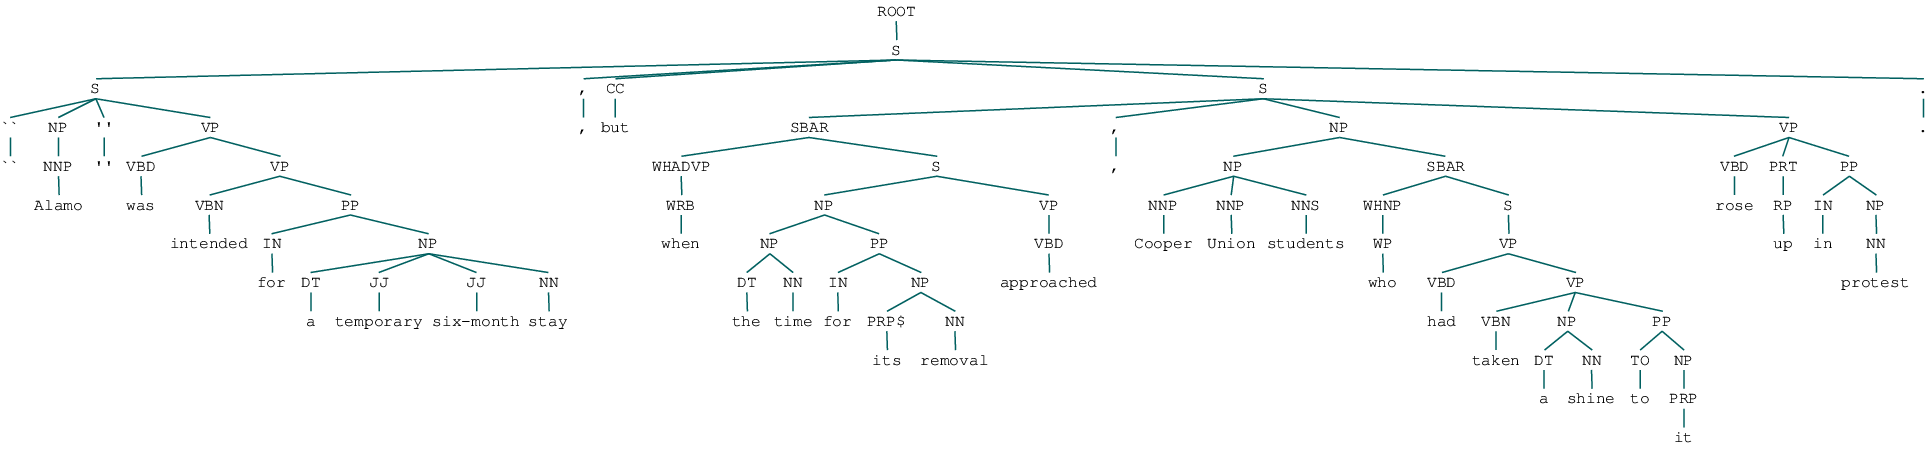

In [23]:
one_sentence_parser("''Alamo'' was intended for a temporary six-month stay, but when the time for its removal approached, Cooper Union students who had taken a shine to it rose up in protest.")